In [252]:
import numpy as np
import pandas as pd

import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from scipy import stats
from sklearn import preprocessing 
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols

import matplotlib.pyplot as plt 
import seaborn as sns
from pandas import Timestamp

import xgboost as xgb
from xgboost import XGBRegressor 
from xgboost.sklearn import XGBClassifier # sklearn’s Grid Search with parallel processing
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV

import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
sample = pd.read_csv('DF_File_sample.csv')

In [3]:
sample.head()

,Brand,SKU10,DemandCustomer,Year,Quarter,Month_No,Week_No,Sales,W_Nielsen
0,ARW,62338-91101,ALL OTHERS - US,2015,1,1,1,205.0,0.0
1,ARW,62338-91101,ALL OTHERS - US,2015,1,1,2,2202.0,0.0
2,ARW,62338-91101,ALL OTHERS - US,2015,1,1,3,2527.0,0.0
3,ARW,62338-91101,ALL OTHERS - US,2015,1,1,4,680.0,0.0
4,ARW,62338-91101,ALL OTHERS - US,2015,1,2,5,1149.0,0.0


In [4]:
sample.shape

(15072, 9)

In [5]:
sample.dtypes

Brand              object
SKU10              object
DemandCustomer     object
Year                int64
Quarter             int64
Month_No            int64
Week_No             int64
Sales             float64
W_Nielsen         float64
dtype: object

In [9]:
var = 'Year_2'
target = 'Sales'
df_test = sample
samplet_copy = sample.copy()
col = df_test.loc[:, df_test.columns!='Sales'].columns

In [13]:
# check and remove constant columns
colsToRemove = []
for col in df_test.columns:
    if df_test.dtypes[col]!='object':
        if df_test[col].std() == 0: 
            colsToRemove.append(col)
        
# remove constant columns in the training set
df_test.drop(colsToRemove, axis=1, inplace=True)

print("Removed `{}` Constant Columns\n".format(len(colsToRemove)))
print(colsToRemove)

Removed `0` Constant Columns

[]


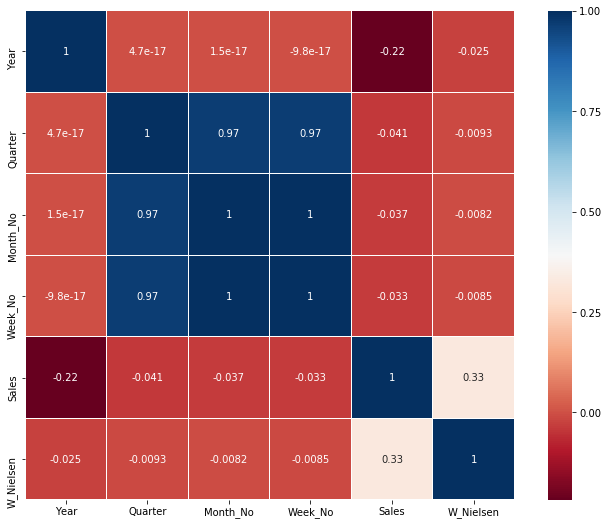

In [14]:
colormap = plt.cm.RdBu
corrmat =df_test.corr()
plt.subplots(figsize = (12, 9))
sns.heatmap(corrmat,  linewidths=0.1, vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [16]:
vars_to_object = ['Year', 'Quarter', 'Month_No', 'Week_No']
for i in vars_to_object:
    new_var = i + '_2'
    df_test[new_var] = df_test[i].astype(str)

In [17]:
df_test.columns

Index(['Brand', 'SKU10', 'DemandCustomer', 'Year', 'Quarter', 'Month_No',
       'Week_No', 'Sales', 'W_Nielsen', 'Year_2', 'Quarter_2', 'Month_No_2',
       'Week_No_2'],
      dtype='object')

In [19]:
df_test_copy = df_test.copy()

In [20]:
def var_imp(var, target, df_test):
    # Test whether a target distribution differs from a normal distribution
    norm_stats, p_norm = stats.normaltest(df_test[target])
    if p_norm < 0.05:
        # ANOVA
        var_in_formula = "Q('{}')".format(var) 
        formula = "{} ~ {}".format(target, var)
        model = ols(formula, df_test).fit() 
        table = sm.stats.anova_lm(model, typ=2) 
        stat_a, p_a = table.iloc[0,2], table.iloc[0,3]
        print('Statistics ANOVA of %s: %.3f, %.3f' % (var, stat_a, p_a))
    else:
        # kruskal
        kruskal = scipy.stats.kruskal(*[group[target].values for name, group in df_test.groupby(var)])
        stat_k, p_k = [kruskal[i] for i in range(0, 2)] 
        print('Statistics = %.3f, %.3f' % (stat_k, p_k))

In [21]:
vars_for_creation = ['Year_2', 'Quarter_2', 'Month_No_2', 'Week_No_2']

In [22]:
def var_create(vars_for_creation, df_test):
    global var_test
    var_test = vars_for_creation.copy()
    for i in range(0, len(vars_for_creation)):
        for j in range(i + 1, len(vars_for_creation)):
            if i<j:
                new_col_name = df_test.loc[:,vars_for_creation[i]].name + '_' + df_test.loc[:,vars_for_creation[j]].name
                df_test[new_col_name] = df_test.loc[:,vars_for_creation[i]] + df_test.loc[:,vars_for_creation[j]] 
                var_test.append(new_col_name)

In [23]:
var_create(vars_for_creation, df_test)

In [24]:
df_test.head()

,Brand,SKU10,DemandCustomer,Year,Quarter,Month_No,Week_No,Sales,W_Nielsen,Year_2,Quarter_2,Month_No_2,Week_No_2,Year_2_Quarter_2,Year_2_Month_No_2,Year_2_Week_No_2,Quarter_2_Month_No_2,Quarter_2_Week_No_2,Month_No_2_Week_No_2
0,ARW,62338-91101,ALL OTHERS - US,2015,1,1,1,205.0,0.0,2015,1,1,1,20151,20151,20151,11,11,11
1,ARW,62338-91101,ALL OTHERS - US,2015,1,1,2,2202.0,0.0,2015,1,1,2,20151,20151,20152,11,12,12
2,ARW,62338-91101,ALL OTHERS - US,2015,1,1,3,2527.0,0.0,2015,1,1,3,20151,20151,20153,11,13,13
3,ARW,62338-91101,ALL OTHERS - US,2015,1,1,4,680.0,0.0,2015,1,1,4,20151,20151,20154,11,14,14
4,ARW,62338-91101,ALL OTHERS - US,2015,1,2,5,1149.0,0.0,2015,1,2,5,20151,20152,20155,12,15,25


In [25]:
var_test

['Year_2',
 'Quarter_2',
 'Month_No_2',
 'Week_No_2',
 'Year_2_Quarter_2',
 'Year_2_Month_No_2',
 'Year_2_Week_No_2',
 'Quarter_2_Month_No_2',
 'Quarter_2_Week_No_2',
 'Month_No_2_Week_No_2']

In [26]:
for var in var_test:
    var_imp(var, target, df_test)

Statistics ANOVA of Year_2: 251.348, 0.000
Statistics ANOVA of Quarter_2: 16.362, 0.000
Statistics ANOVA of Month_No_2: 5.458, 0.000
Statistics ANOVA of Week_No_2: 2.568, 0.000
Statistics ANOVA of Year_2_Quarter_2: 64.017, 0.000
Statistics ANOVA of Year_2_Month_No_2: 21.350, 0.000
Statistics ANOVA of Year_2_Week_No_2: 5.498, 0.000
Statistics ANOVA of Quarter_2_Month_No_2: 5.458, 0.000
Statistics ANOVA of Quarter_2_Week_No_2: 2.568, 0.000
Statistics ANOVA of Month_No_2_Week_No_2: 2.568, 0.000


In [31]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

for i in range(0, df_test.shape[1]):
    if df_test.dtypes[i]=='object':
        df_test[df_test.columns[i]] = le.fit_transform(df_test[df_test.columns[i]])

In [32]:
df_test.head()

,Brand,SKU10,DemandCustomer,Year,Quarter,Month_No,Week_No,Sales,W_Nielsen,Year_2,Quarter_2,Month_No_2,Week_No_2,Year_2_Quarter_2,Year_2_Month_No_2,Year_2_Week_No_2,Quarter_2_Month_No_2,Quarter_2_Week_No_2,Month_No_2_Week_No_2
0,0,2,0,2015,1,1,1,205.0,0.0,0,0,0,0,0,0,0,0,0,4
1,0,2,0,2015,1,1,2,2202.0,0.0,0,0,0,11,0,0,11,0,5,9
2,0,2,0,2015,1,1,3,2527.0,0.0,0,0,0,22,0,0,22,0,6,16
3,0,2,0,2015,1,1,4,680.0,0.0,0,0,0,33,0,0,33,0,7,17
4,0,2,0,2015,1,2,5,1149.0,0.0,0,0,4,44,0,4,44,1,8,18


## Modeling:

In [170]:
data = data.iloc[:, :9].copy()

In [266]:
data

,Brand,SKU10,DemandCustomer,Year,Quarter,Month_No,Week_No,Sales,W_Nielsen,year_week,pre_date
0,0,2,0,2015,1,1,1,205.0,0.0,2015-1,2015-01-01
1,0,2,0,2015,1,1,2,2202.0,0.0,2015-2,2015-01-08
2,0,2,0,2015,1,1,3,2527.0,0.0,2015-3,2015-01-15
3,0,2,0,2015,1,1,4,680.0,0.0,2015-4,2015-01-22
4,0,2,0,2015,1,2,5,1149.0,0.0,2015-5,2015-01-29
...,...,...,...,...,...,...,...,...,...,...,...
15067,2,0,10,2020,4,12,49,0.0,0.0,2020-49,2020-12-03
15068,2,0,10,2020,4,12,50,0.0,0.0,2020-50,2020-12-10
15069,2,0,10,2020,4,12,51,0.0,0.0,2020-51,2020-12-17
15070,2,0,10,2020,4,12,52,0.0,0.0,2020-52,2020-12-24


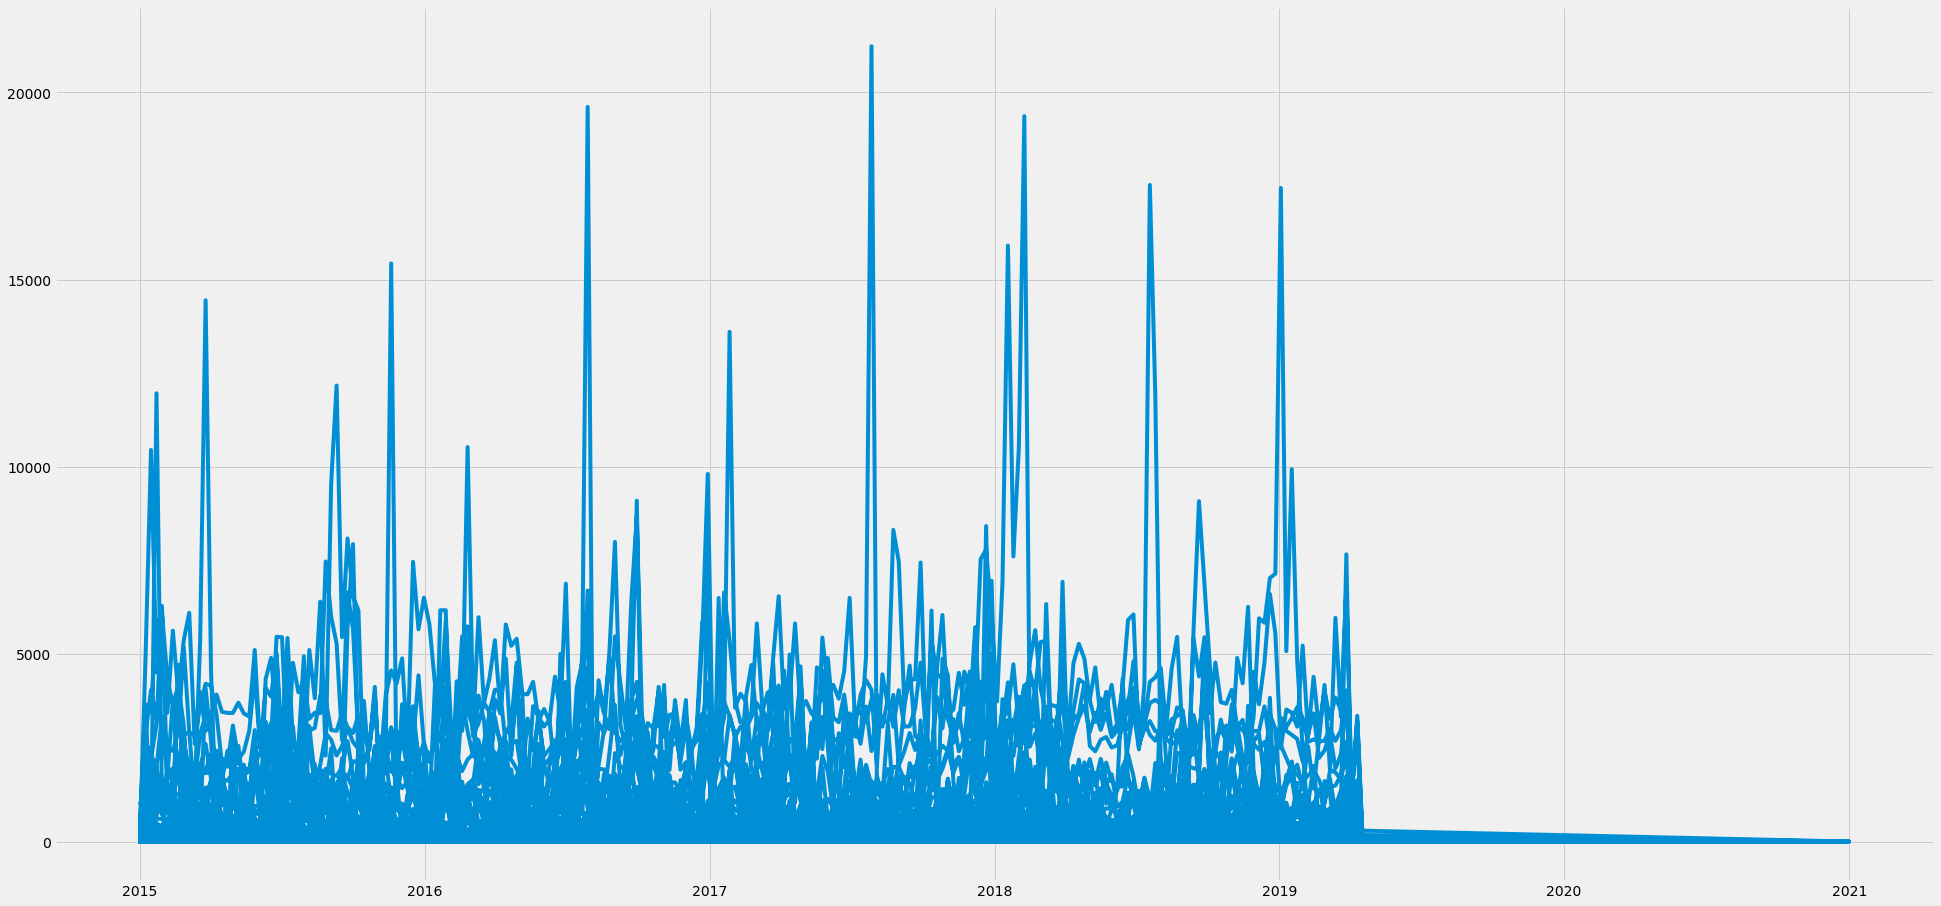

In [272]:
data['year_week'] = data['Year'].astype(str) + '-' + data['Week_No'].astype(str)
data['pre_date'] = data['year_week'].apply(lambda x: datetime.datetime.strptime(x + '-4',  "%G-%V-%w"))
data.index = data['pre_date']
data.drop(['year_week', 'pre_date'], axis =1, inplace = True)


fig = plt.figure(figsize=(30,15))
ax = plt.axes()
x = np.linspace(0, 10, 1000)
ax.plot(data['pre_date'], data['Sales']);

In [277]:
data.head()

,Brand,SKU10,DemandCustomer,Year,Quarter,Month_No,Week_No,Sales,W_Nielsen
pre_date,,,,,,,,,
2015-01-01,0,2,0,2015,1,1,1,205.0,0.0
2015-01-08,0,2,0,2015,1,1,2,2202.0,0.0
2015-01-15,0,2,0,2015,1,1,3,2527.0,0.0
2015-01-22,0,2,0,2015,1,1,4,680.0,0.0
2015-01-29,0,2,0,2015,1,2,5,1149.0,0.0


In [299]:
data_for_pred = data[(data.index < '2019-03-01')]

In [307]:
data_for_pred.index = pd.Series(data_for_pred.index).apply(lambda x: x.replace(day=1))

In [311]:
data_for_pred['Sales'] = data_for_pred.groupby(data_for_pred.index)['Sales'].transform('mean').values     

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [312]:
data_for_pred

,Brand,SKU10,DemandCustomer,Year,Quarter,Month_No,Week_No,Sales,W_Nielsen
pre_date,,,,,,,,,
2015-01-01,0,2,0,2015,1,1,1,623.226667,0.0
2015-01-01,0,2,0,2015,1,1,2,623.226667,0.0
2015-01-01,0,2,0,2015,1,1,3,623.226667,0.0
2015-01-01,0,2,0,2015,1,1,4,623.226667,0.0
2015-01-01,0,2,0,2015,1,2,5,623.226667,0.0
...,...,...,...,...,...,...,...,...,...
2019-01-01,2,0,10,2019,1,2,5,694.666667,0.0
2019-02-01,2,0,10,2019,1,2,6,548.736111,0.0
2019-02-01,2,0,10,2019,1,2,7,548.736111,0.0


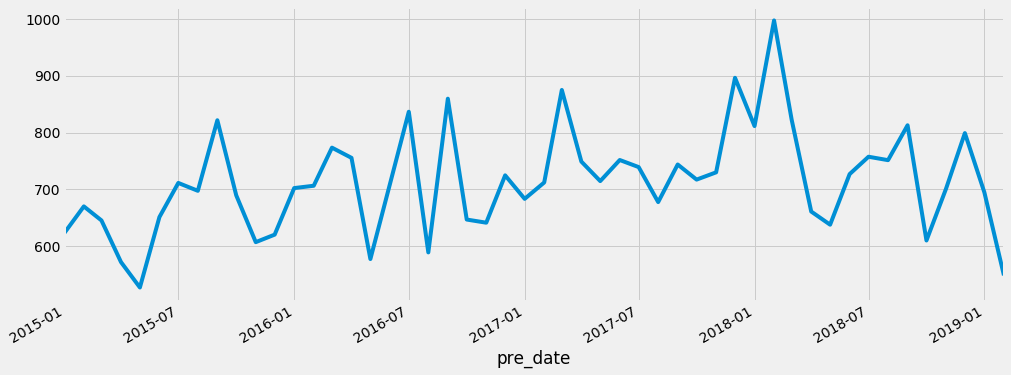

In [313]:
data_for_pred['Sales'].plot(figsize=(15, 6))
plt.show()

In [315]:
# Определите p, d и q в диапазоне 0-2
p = d = q = range(0, 2)
# Сгенерируйте различные комбинации p, q и q
pdq = list(itertools.product(p, d, q))
# Сгенерируйте комбинации сезонных параметров p, q и q
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [279]:
data_for_pred.head()

,Brand,SKU10,DemandCustomer,Year,Quarter,Month_No,Week_No,Sales,W_Nielsen
pre_date,,,,,,,,,
2015-01-01,0,2,0,2015,1,1,1,205.0,0.0
2015-01-08,0,2,0,2015,1,1,2,2202.0,0.0
2015-01-15,0,2,0,2015,1,1,3,2527.0,0.0
2015-01-22,0,2,0,2015,1,1,4,680.0,0.0
2015-01-29,0,2,0,2015,1,2,5,1149.0,0.0


#  Forecasting a Time Series:

In [280]:
# Train / Test split

data_ser = pd.Series(data_for_pred.index.unique())
train_limit = data_ser[data_ser.index <= len(data_ser)*.8].iloc[-1]

In [281]:
train = data_for_pred[data_for_pred.index <= train_limit]
test = data_for_pred[data_for_pred.index > train_limit]

In [282]:
train.shape[0]/data_for_pred.shape[0]

0.8027522935779816

In [263]:
train.shape

(3696, 11)

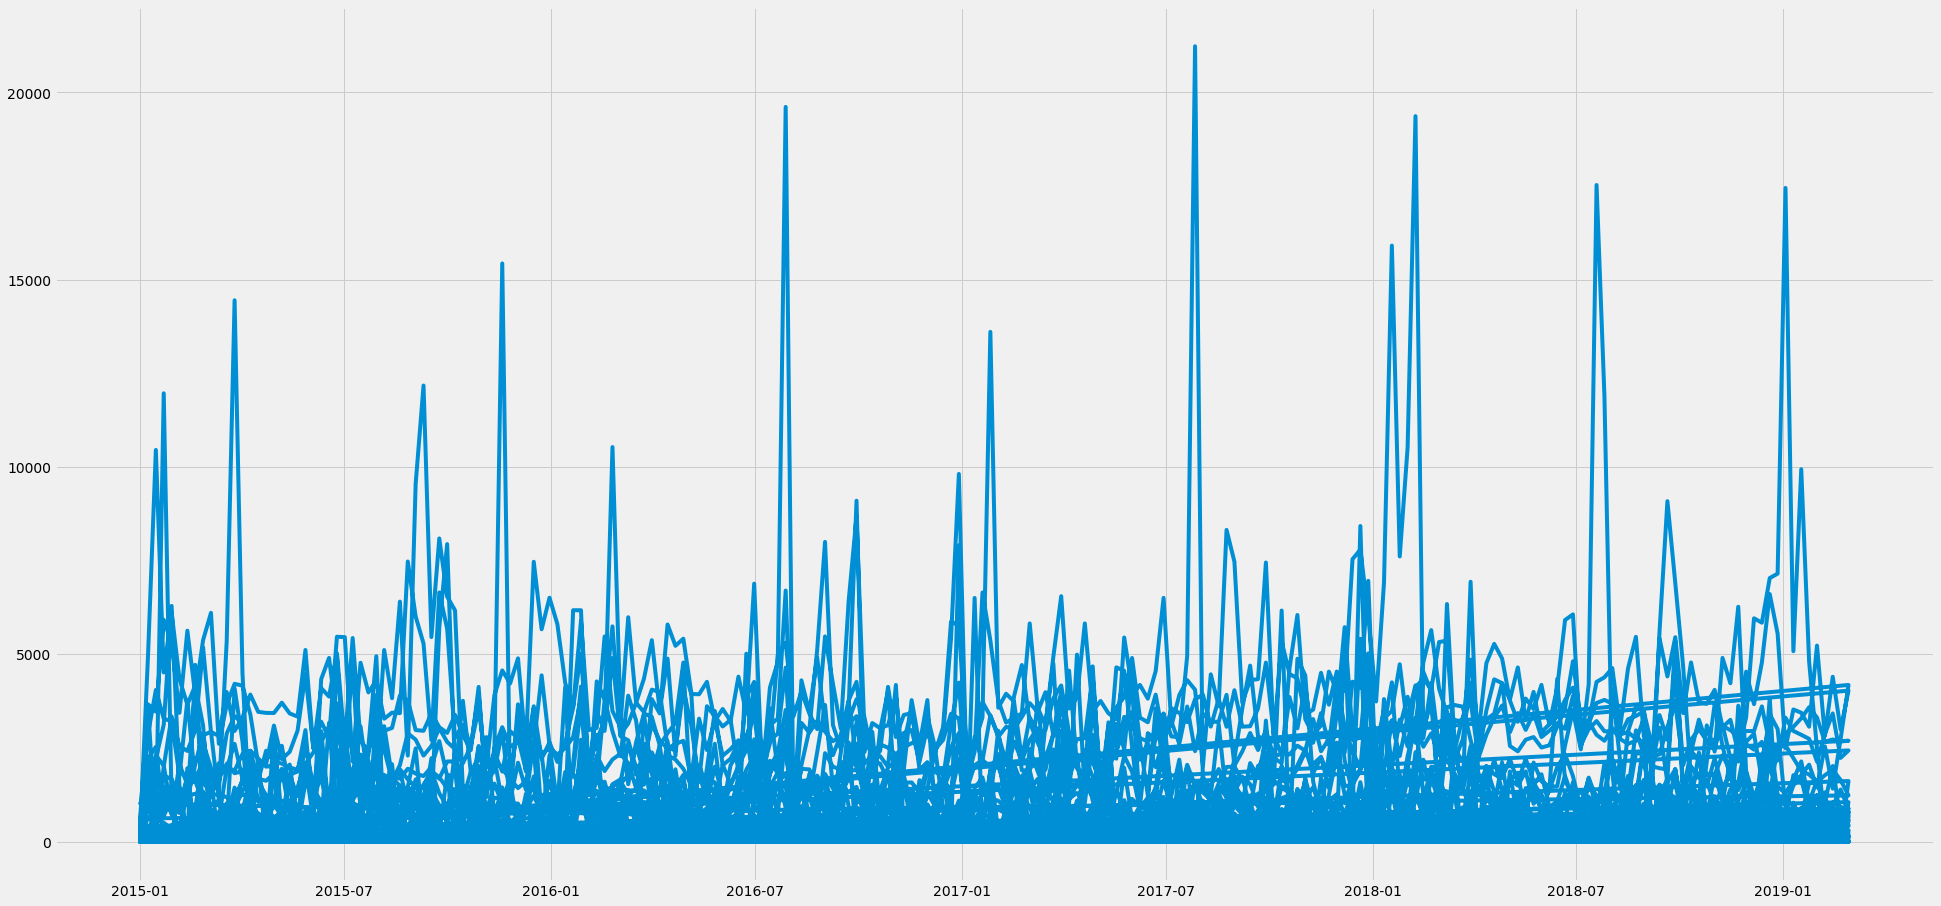

In [283]:
fig = plt.figure(figsize=(30,15))
ax = plt.axes()
x = np.linspace(0, 10, 1000)
ax.plot(data_for_pred.index, data_for_pred['Sales']);

In [284]:
train.head()

,Brand,SKU10,DemandCustomer,Year,Quarter,Month_No,Week_No,Sales,W_Nielsen
pre_date,,,,,,,,,
2015-01-01,0,2,0,2015,1,1,1,205.0,0.0
2015-01-08,0,2,0,2015,1,1,2,2202.0,0.0
2015-01-15,0,2,0,2015,1,1,3,2527.0,0.0
2015-01-22,0,2,0,2015,1,1,4,680.0,0.0
2015-01-29,0,2,0,2015,1,2,5,1149.0,0.0


In [286]:
data.dtypes

Brand               int32
SKU10               int32
DemandCustomer      int32
Year                int64
Quarter             int64
Month_No            int64
Week_No             int64
Sales             float64
W_Nielsen         float64
dtype: object

In [287]:
X_train = train.loc[:, train.columns!='Sales']
y_train  =  train['Sales']
X_test = test.loc[:, test.columns!='Sales']
y_test = test['Sales']

In [288]:
X_train

,Brand,SKU10,DemandCustomer,Year,Quarter,Month_No,Week_No,W_Nielsen
pre_date,,,,,,,,
2015-01-01,0,2,0,2015,1,1,1,0.0
2015-01-08,0,2,0,2015,1,1,2,0.0
2015-01-15,0,2,0,2015,1,1,3,0.0
2015-01-22,0,2,0,2015,1,1,4,0.0
2015-01-29,0,2,0,2015,1,2,5,0.0
...,...,...,...,...,...,...,...,...
2018-04-05,2,0,10,2018,2,4,14,0.0
2018-04-12,2,0,10,2018,2,4,15,0.0
2018-04-19,2,0,10,2018,2,4,16,0.0


# Modeling:

In [195]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return (np.mean(np.abs((y_true - y_pred))) * 100 / np.mean(np.abs((y_true)))) 

## Ridge regression:

In [86]:
from sklearn.linear_model import Ridge

In [191]:
X_test.head()

,Brand,SKU10,DemandCustomer,Year,Quarter,Month_No,Week_No,W_Nielsen
252,0,2,0,2019,4,11,44,0.0
253,0,2,0,2019,4,11,45,0.0
254,0,2,0,2019,4,11,46,0.0
255,0,2,0,2019,4,11,47,0.0
256,0,2,0,2019,4,12,48,0.0


In [219]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [193]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

from sklearn.linear_model import Ridge

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

linridge = Ridge(alpha=20.0).fit(X_train_scaled, y_train)

In [220]:
for this_alpha in [0, 1, 10, 20, 50, 100, 1000]:
    linridge = Ridge(alpha = this_alpha).fit(X_train_scaled, y_train)
    r2_train = linridge.score(X_train_scaled, y_train)
    r2_test = linridge.score(X_test_scaled, y_test)
    num_coeff_bigger = np.sum(abs(linridge.coef_) > 1.0)
    predicted = linridge.predict(X_test_scaled); 
    
    MAPE=mean_absolute_percentage_error(y_test, predicted);
    print(MAPE);

141.96929352971904
141.9777405100824
141.9378922102549
141.8338848732029
141.38882569977127
140.2969188891701
122.61916184632983


## Lasso regression:

In [100]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

linlasso = Lasso(alpha=2.0, max_iter = 10000).fit(X_train_scaled, y_train)

print('Lasso regression:')
print('lasso regression linear model intercept: {}'
     .format(linlasso.intercept_))
print('lasso regression linear model coeff:\n{}'
     .format(linlasso.coef_))
print('Non-zero features: {}'
     .format(np.sum(linlasso.coef_ != 0)))
print('R-squared score (training): {:.3f}'
     .format(linlasso.score(X_train_scaled, y_train)))
print('R-squared score (test): {:.3f}\n'
     .format(linlasso.score(X_test_scaled, y_test)))
print('Features with non-zero weight (sorted by absolute magnitude):')

for e in sorted (list(zip(list(X_train), linlasso.coef_)),
                key = lambda e: -abs(e[1])):
    if e[1] != 0:
        print('\t{}, {:.3f}'.format(e[0], e[1]))

Lasso regression:
lasso regression linear model intercept: 722.6984522094538
lasso regression linear model coeff:
[ 361.42299      71.93301654 -270.79910808 -649.22004449  -91.70619396
   -0.            0.         2550.94752719]
Non-zero features: 6
R-squared score (training): 0.177
R-squared score (test): 0.157

Features with non-zero weight (sorted by absolute magnitude):
	W_Nielsen, 2550.948
	Year, -649.220
	Brand, 361.423
	DemandCustomer, -270.799
	Quarter, -91.706
	SKU10, 71.933


## Lasso regression with regularization parameter: alpha:

In [119]:
for alpha in [0.005, 0.005, 0.03]:
    linlasso = Lasso(alpha, max_iter = 10000).fit(X_train_scaled, y_train)
    r2_train = linlasso.score(X_train_scaled, y_train)
    r2_test = linlasso.score(X_test_scaled, y_test)
    predicted = linlasso.predict(X_test_scaled); 
    
    MAPE=mean_absolute_percentage_error(y_test, predicted);
    print(MAPE);

100.70053221329314
100.69517132813704
100.66965748130107


## Support Vector Machines:

In [116]:
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

for C in [0.5, 1, 2, 3, 5, 10, 20, 50]:
    svr=SVR(kernel='linear', C=C, epsilon=0.6).fit(X_train_scaled, y_train)
    r2_train = svr.score(X_train_scaled, y_train)
    r2_test = svr.score(X_test_scaled, y_test)
    predicted = svr.predict(X_test_scaled);
    
    
    MAPE=mean_absolute_percentage_error(y_test, predicted);
    print(MAPE);

96.01859037451148
95.51217709832075
94.89751638519961
94.3757533169927
93.50957831759825
91.88735730016583
89.99203385698964
88.61107690232056


# XGB:

In [54]:
def run_xgb(train_X, train_y, val_X, val_y, test_X):
    params = {'objective': 'reg:linear', 
              'eval_metric': 'rmse',
              'eta': 0.005,
              'max_depth': 5, 
              'subsample': 0.7, 
              'colsample_bytree': 0.5,
              'alpha':0.75,
              'lambda':0.45,
              'random_state': 42, 
              'silent': True}
              
    
    tr_data = xgb.DMatrix(train_X, train_y)
    va_data = xgb.DMatrix(val_X, val_y)

    watchlist = [(tr_data, 'train'), (va_data, 'valid')]

    model_xgb = xgb.train(params, 
                          tr_data, 
                          2000, 
                          watchlist, 
                          maximize=False, 
                          early_stopping_rounds = 1000, 
                          verbose_eval=100)

    dtest = xgb.DMatrix(test_X)
    xgb_pred_y = np.expm1(model_xgb.predict(dtest, ntree_limit=model_xgb.best_ntree_limit))

    return xgb_pred_y, model_xgb

In [55]:
pred_test_xgb, model_xgb = run_xgb(X_train, y_train, X_Test, y_test, test.loc[:, test.columns!='Sales'])

[0]	train-rmse:1162.55	valid-rmse:1248.99
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 1000 rounds.
[100]	train-rmse:969.916	valid-rmse:1056.2
[200]	train-rmse:849.094	valid-rmse:936.602
[300]	train-rmse:761.954	valid-rmse:849.601
[400]	train-rmse:716.99	valid-rmse:806.295
[500]	train-rmse:679.552	valid-rmse:770.117
[600]	train-rmse:653.265	valid-rmse:746.558
[700]	train-rmse:632.842	valid-rmse:727.269
[800]	train-rmse:618.632	valid-rmse:714.969
[900]	train-rmse:606.352	valid-rmse:704.963
[1000]	train-rmse:597.304	valid-rmse:698.225
[1100]	train-rmse:589.63	valid-rmse:692.67
[1200]	train-rmse:582.578	valid-rmse:688.088
[1300]	train-rmse:576.653	valid-rmse:684.911
[1400]	train-rmse:571.005	valid-rmse:681.047
[1500]	train-rmse:565.559	valid-rmse:678.251
[1600]	train-rmse:560.982	valid-rmse:675.771
[1700]	train-rmse:556.75	valid-rmse:673.988
[1800]	train-rmse:552.214	valid-rmse:671.637
[1900]	train-rm

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: overflow encountered in expm1


In [69]:
# train data with union columns
data2 = df_test.iloc[:, [0,1,2,3,4,7,8,-1]]
dev = data.sample(frac = 0.7)
test = data.loc[[ind for ind in data.index if ind not in dev.index], ]






# LightGBM:

In [ ]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 35,
        "learning_rate" : 0.005,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 42,
        "verbosity" : -1,
        "random_seed": 42
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 5000, 
                      valid_sets=[lgval], 
                      early_stopping_rounds=100, 
                      verbose_eval=50, 
                      evals_result=evals_result)
    
    pred_test_y = np.expm1(model.predict(test_X, num_iteration=model.best_iteration))
    return pred_test_y, model, evals_result

In [ ]:
pred_test, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, X_test)

In [ ]:
# feature importance
print("Features Importance...")
gain = model.feature_importance('gain')
featureimp = pd.DataFrame({'feature':model.feature_name(), 
                   'split':model.feature_importance('split'), 
                   'gain':100 * gain / gain.sum()}).sort_values('gain', ascending=False)
print(featureimp)

In [ ]:
def run_cat_b(train_X, train_y, val_X, val_y, test_X):
   cb_model = CatBoostRegressor(iterations=1000, 
                                learning_rate=0.1, 
                                depth=8, 
                                l2_leaf_reg=20, 
                                bootstrap_type='Bernoulli',  
                                eval_metric='RMSE', 
                                metric_period=50, 
                                od_type='Iter', 
                                od_wait=45, 
                                random_seed=17, 
                                allow_writing_files=False)
                                
    cb_model.fit(train_X, 
                 train_y, 
                 eval_set=(val_X, val_y), 
                 cat_features=[], 
                 use_best_model=True, 
                 verbose=True)
                 
    pred_test_y = np.expm1(model.predict(test_X, num_iteration=model.best_iteration))
    return pred_test_y, model, evals_result 
    
    
    
    oof_preds[val_idx] = cb_model.predict(val_x)
    sub_preds += cb_model.predict(test) / folds.n_splits
    print("Fold %2d RMSLE : %.6f" % (n_fold+1, rmsle(np.exp(val_y)-1, np.exp(oof_preds[val_idx])-1)))

print("Full RMSLE score %.6f" % rmsle(np.exp(target)-1, np.exp(oof_preds)-1)) 
subm['target'] = np.exp(sub_preds)-1

## Tunning Parameters:

In [22]:
xgb_model = xgb.XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.1,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=1000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)

In [ ]:
learning_rate = np.arange(0.01, 0.5, 0.02)
parameters = dict(learning_rate=learning_rate)

print_parameters(learning_rate, 'learning_rate', parameters)

In [ ]:
n_estimators = range(100, 1000, 100)
parameters = dict(n_estimators=n_estimators)

print_parameters(n_estimators, 'n_estimators', parameters)

In [ ]:
max_depth = range(0, 5)
parameters = dict(max_depth=max_depth)

print_parameters(max_depth, 'max_depth', parameters)

In [ ]:
subsample = np.arange(0.2, 1., 0.2)
parameters = dict(subsample=subsample)

print_parameters(subsample, 'subsample', parameters)

In [ ]:
colsample_bytree = np.arange(0.2, 1.2, 0.2)
parameters = dict(colsample_bytree=colsample_bytree)

print_parameters(colsample_bytree, 'colsample_bytree', parameters)

In [ ]:
gamma = np.arange(0.001, 0.1, 0.02)
parameters = dict(gamma=gamma)

print_parameters(gamma, 'gamma', parameters)

In [ ]:
min_child_weight = np.arange(0.5, 2.0, 0.2)
parameters = dict(min_child_weight=min_child_weight)

print_parameters(min_child_weight, 'min_child_weight', parameters)

In [ ]:
parameters = {  
                'colsample_bytree':[1],
                'subsample':[0.4,0.6],
                'gamma':[0.041],
                'min_child_weight':[1.1,1.3],
                'max_depth':[3,5],
                'learning_rate':[0.2, 0.25],
                'n_estimators':[400],                                                                    
                'reg_alpha':[0.75],
                'reg_lambda':[0.45],
                'seed':[10]

In [ ]:
grid_search = GridSearchCV(estimator = xgb_model,
                        param_grid = parameters,
                        scoring = 'neg_mean_squared_error',
                        cv = 5,
                        n_jobs = -1)

In [ ]:
xgb_model = grid_search.fit(X_train, y_train)
best_score = grid_search.best_score_
best_parameters = grid_search.best_params_
accuracies = cross_val_score(estimator=xgb_model, X=X_train, y=y_train, cv=10)
accuracies.mean()
y_pred = xgb_model.predict(X_test)
y_pred = np.floor(np.expm1(y_pred))